## Imports and variables

In [1]:
import cython
#For C++ compiler: https://visualstudio.microsoft.com/thank-you-downloading-visual-studio/?sku=BuildTools&rel=16
%load_ext Cython
import dask
from dask.distributed import Client, Semaphore

# Counting until a billion:
num = 1000000000

Before we begin we need to start importing the packages of interest, namely: dask and cython.  Note: to use cython you also need to install a C++ compiler.  The easiest thing to do is to probably install VS Code with the C++ extension.  Also to use dask visualizations you will need to install graphviz with both:

conda install -c conda-forge graphviz

conda install -c conda-forge python-graphviz


## Heavy Computation in Python Example
Now we can start with our simple benchmark example: "computer to count to an arbitrary number".

In [2]:
%%time

def count(start, end):
    result = 0
    for i in range(start, end):
        result += 1
    return result

print('result:', count(0, num))

result: 1000000000
Wall time: 1min 12s


While there are much better ways to do this, let's assume that the code cannot be altered.  How can we speed it up?  One great option is using dask.

## Defining our Local Cluster

To start using dask we need to define a cluster.  The cluster can be established locally or remotely (accorss several computers for example); here we will spin one up locally.  Because the above problem is one mainly of computation, I am going to parallelize the code across processes.  If I was looking for responsiveness or dealing with a I/O problem with little computation, you would be better sever using multiple threads.

Because my computer has 8 cores I will set the number of workers to 8 (because I know that it can do no better than 8 and any less will leave idling resources.  Threads per worker is 1 because the jobs I will submit to the cluster will be a single processes (so multiple threads per process won't be of use).  Finally the memory limit per worker is 24GB split equally between them.  My total ram is 32GB, and I want to reserve some memory for the desktop and associated processes.

In [3]:
# Defining the local cluster:
workers = 8
client = Client(n_workers=workers,
                threads_per_worker=1,
                memory_limit=f'{24/workers}GB')
client

Client Scheduler: tcp://127.0.0.1:53029 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 24.00 GB


## Translating our Example into Dask Futures

To translate our function over to our dask cluster we can effectively copy and paste it.  The only change I make below is having the function 

In [4]:
# Defining the inputs to the cluster and function:
chunk_start = [i for i in range(0, num, int(num/workers))]
chunk_end = chunk_start[1:] + [num]

In [6]:
%%time
# Submitting the function and inputs to the cluster:
futures = []
for i, j in zip(chunk_start, chunk_end):
    future = client.submit(count, i, j)
    futures.append(future)
results = client.gather(futures)

Wall time: 11.4 s


In [9]:
sum(results)

1000000000

Putting everything together:

In [7]:
%%time

chunk_start = [i for i in range(0, num, int(num/workers))]
chunk_end = chunk_start[1:] + [num]

futures = []
for i, j in zip(chunk_start, chunk_end):
    future = client.submit(count, i, j)
    futures.append(future)
results = client.gather(futures)

print('result:', sum(results))

result: 1000000000
Wall time: 11.7 s


## Lazy Evaluation with Dask Delayed

In [10]:
%%time

def chunk_inc(i, j):
    result = 0
    for k in range(i, j):
        result += 1
    return result

chunk_start = [i for i in range(0, num, int(num/workers))]
chunk_end = chunk_start[1:] + [num]

lazies = []
for i, j in zip(chunk_start, chunk_end):
    lazies.append(dask.delayed(chunk_inc)(i, j))

Wall time: 1 ms


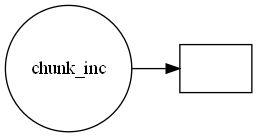

In [11]:
lazies[0].visualize(rankdir='LR')

In [13]:
%%time
results = dask.compute(*lazies)
sum(results)

Wall time: 11.5 s


1000000000

In [14]:
@dask.delayed
def chunk_dec(x):
    return x - 1000000

@dask.delayed
def chunk_diff(x, y):
    return x - y

new_lazies = [chunk_diff(i, chunk_dec(i)) for i in lazies]

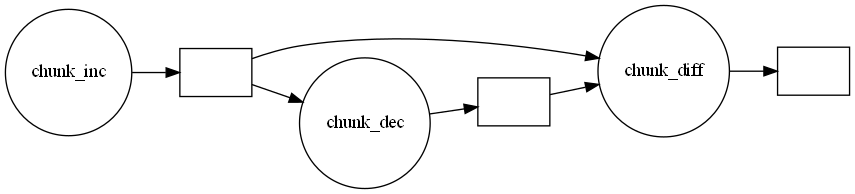

In [15]:
new_lazies[0].visualize(rankdir='LR')

In [16]:
%%time
results = dask.compute(*new_lazies)
results

Wall time: 11.9 s


(1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000)

## Just Type Declarations with Cython

In [17]:
%%cython --annotate

def c_count(start, end):
    result = 0
    for i in range(start, end):
        result += 1
    return result

In [18]:
%%cython --annotate
import cython

def c_count(start: cython.int, end: cython.int):
    result: cython.int = 0
    for i in range(start, end):
        result += 1
    return result

In [20]:
%%cython
import cython

def c_count(start: cython.int, end: cython.int):
    result: cython.int = 0
    for i in range(start, end):
        result += 1
    return result

In [22]:
%%time
print('result:', c_count(0, num))

result: 1000000000
Wall time: 1 ms


In [23]:
%%cython --annotate

cpdef int c_count(int start, int end):
    cdef int result = 0
    for i in range(start, end):
        result += 1
    return result

In [26]:
%%cython
cpdef int c_count(int start, int end):
    cdef int result = 0
    for i in range(start, end):
        result += 1
    return result

In [27]:
%%time
print('result:', c_count(0, num))

result: 1000000000
Wall time: 0 ns
